In [1]:
import numpy as np
from helpers import *
from implementations import * 
from utilities import * #todo specify with the ones we use

In [2]:
# Load the dataset
x_tr, x_te, y_tr, tr_id, te_id = load_csv_data('dataset', True)
# Transform our y values from {-1,1} to {0,1} because that’s what logistic regression tests expect https://edstem.org/eu/courses/1605/discussion/134447
y_tr[y_tr == -1] = 0

### Data exploration and data cleaning

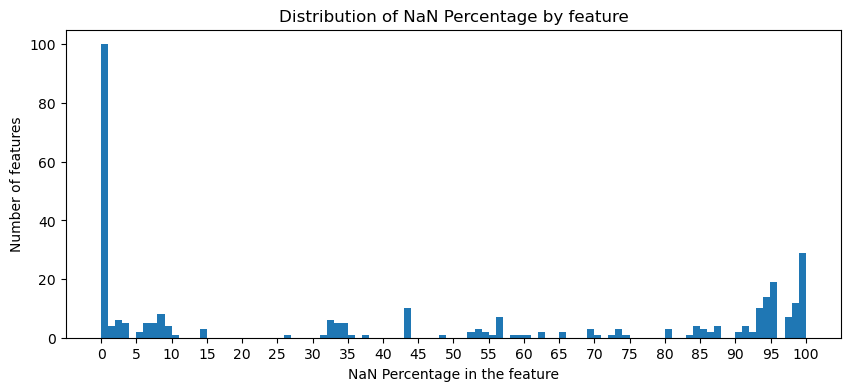

In [3]:
"""
We analyze the percentage of NaN values in each feature to determine an appropriate cutoff threshold.
Features with too many NaN values are less useful, but we don’t want to remove too many features.

number of features left for each threshold value:
   5% nan: 115 -> 35% of features left
  50% nan: 174 -> 54%
  65% nan: 194 -> 60%
  90% nan: 222 -> 69%
we pick a threshold of 50% for now.
TODO: test difference in accuracy with different thresholds {5, 50, 65, 90}%
"""

# Count the percentage of NaN values per feature
nan_percentage_by_feature = (np.sum(np.isnan(x_tr), axis=0) / len(x_tr)) * 100

# Plot the resulting distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.hist(nan_percentage_by_feature, bins=100)
plt.title("Distribution of NaN Percentage by feature")
plt.xlabel("NaN Percentage in the feature")
plt.ylabel("Number of features")
plt.xticks(np.arange(start=0, stop=101, step=5))

# A threshold of maximum 50% of NaN values in a feature seems like a reasonable tradeoff
MAX_NAN_PERCENTAGE = 50
mask = nan_percentage_by_feature < MAX_NAN_PERCENTAGE
# So we get rid of the features with more than MAX_NAN_PERCENTAGE % of NaN values
x_tr_threshold = x_tr.copy()[:, mask]
from_tr_threshold_to_original_tr_indices = np.where(mask)[0]
# TODO: je ne crois pas qu’il y ait beson de copy(), on ne va pas changer x_tr

Text(0.5, 1.0, 'Distribution of Unique Values Across Features')

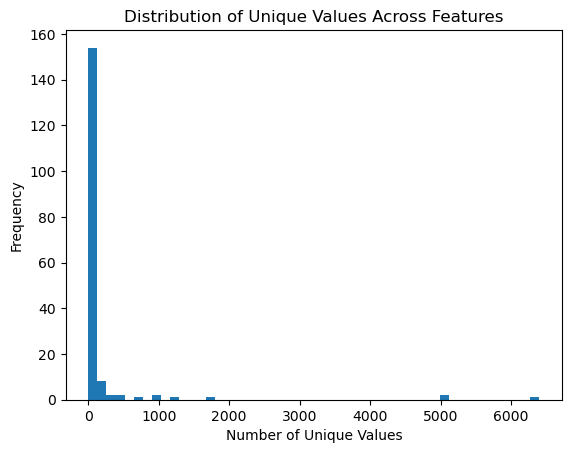

In [4]:
# Our objective is to build a mask to separate numerical and co (categorical/ordinal) data. 
# First we explore the data to see what is the maximum number of unique values for a co feature.

# Compute and plot the distribution of unique values 
unique_counts_and_indices = np.array([[len(np.unique(x_tr_threshold[:, i])),i] for i in range(x_tr_threshold.shape[1])])
unique_counts = unique_counts_and_indices[:,0]

import matplotlib.pyplot as plt

plt.hist(unique_counts, bins=50) #todo naive visualization, just to have an idea
plt.xlabel('Number of Unique Values')
plt.ylabel('Frequency')
plt.title('Distribution of Unique Values Across Features')

In [5]:
# we consider that a feature with less than 10 values can be considered co, and more than 60 values is 
# surely numerical (think about a human having to check 100 options)
# Our goal is still to find the co feature with the most distinct values to use it as a threshold.
unique_counts_and_indices_refined = unique_counts_and_indices[(unique_counts_and_indices[:,0] > 10) & (unique_counts_and_indices[:,0] < 60)]
indices_to_consider = from_tr_threshold_to_original_tr_indices[unique_counts_and_indices_refined[:,1]] #we get back the original indexes of our x_tr to link our findings to the original feature indices.

In [6]:
x_label = np.array(["_STATE", "FMONTH", "IDATE", "IMONTH", "IDAY", "IYEAR", "DISPCODE", "SEQNO", "_PSU", "CTELENUM", "PVTRESD1", "COLGHOUS", "STATERES", "CELLFON3", "LADULT", "NUMADULT", "NUMMEN", "NUMWOMEN", "CTELNUM1", "CELLFON2", "CADULT", "PVTRESD2", "CCLGHOUS", "CSTATE", "LANDLINE", "HHADULT", "GENHLTH", "PHYSHLTH", "MENTHLTH", "POORHLTH", "HLTHPLN1", "PERSDOC2", "MEDCOST", "CHECKUP1", "BPHIGH4", "BPMEDS", "BLOODCHO", "CHOLCHK", "TOLDHI2", "CVDSTRK3", "ASTHMA3", "ASTHNOW", "CHCSCNCR", "CHCOCNCR", "CHCCOPD1", "HAVARTH3", "ADDEPEV2", "CHCKIDNY", "DIABETE3", "DIABAGE2", "SEX", "MARITAL", "EDUCA", "RENTHOM1", "NUMHHOL2", "NUMPHON2", "CPDEMO1", "VETERAN3", "EMPLOY1", "CHILDREN", "INCOME2", "INTERNET", "WEIGHT2", "HEIGHT3", "PREGNANT", "QLACTLM2", "USEEQUIP", "BLIND", "DECIDE", "DIFFWALK", "DIFFDRES", "DIFFALON", "SMOKE100", "SMOKDAY2", "STOPSMK2", "LASTSMK2", "USENOW3", "ALCDAY5", "AVEDRNK2", "DRNK3GE5", "MAXDRNKS", "FRUITJU1", "FRUIT1", "FVBEANS", "FVGREEN", "FVORANG", "VEGETAB1", "EXERANY2", "EXRACT11", "EXEROFT1", "EXERHMM1", "EXRACT21", "EXEROFT2", "EXERHMM2", "STRENGTH", "LMTJOIN3", "ARTHDIS2", "ARTHSOCL", "JOINPAIN", "SEATBELT", "FLUSHOT6", "FLSHTMY2", "IMFVPLAC", "PNEUVAC3", "HIVTST6", "HIVTSTD3", "WHRTST10", "PDIABTST", "PREDIAB1", "INSULIN", "BLDSUGAR", "FEETCHK2", "DOCTDIAB", "CHKHEMO3", "FEETCHK", "EYEEXAM", "DIABEYE", "DIABEDU", "CAREGIV1", "CRGVREL1", "CRGVLNG1", "CRGVHRS1", "CRGVPRB1", "CRGVPERS", "CRGVHOUS", "CRGVMST2", "CRGVEXPT", "VIDFCLT2", "VIREDIF3", "VIPRFVS2", "VINOCRE2", "VIEYEXM2", "VIINSUR2", "VICTRCT4", "VIGLUMA2", "VIMACDG2", "CIMEMLOS", "CDHOUSE", "CDASSIST", "CDHELP", "CDSOCIAL", "CDDISCUS", "WTCHSALT", "LONGWTCH", "DRADVISE", "ASTHMAGE", "ASATTACK", "ASERVIST", "ASDRVIST", "ASRCHKUP", "ASACTLIM", "ASYMPTOM", "ASNOSLEP", "ASTHMED3", "ASINHALR", "HAREHAB1", "STREHAB1", "CVDASPRN", "ASPUNSAF", "RLIVPAIN", "RDUCHART", "RDUCSTRK", "ARTTODAY", "ARTHWGT", "ARTHEXER", "ARTHEDU", "TETANUS", "HPVADVC2", "HPVADSHT", "SHINGLE2", "HADMAM", "HOWLONG", "HADPAP2", "LASTPAP2", "HPVTEST", "HPLSTTST", "HADHYST2", "PROFEXAM", "LENGEXAM", "BLDSTOOL", "LSTBLDS3", "HADSIGM3", "HADSGCO1", "LASTSIG3", "PCPSAAD2", "PCPSADI1", "PCPSARE1", "PSATEST1", "PSATIME", "PCPSARS1", "PCPSADE1", "PCDMDECN", "SCNTMNY1", "SCNTMEL1", "SCNTPAID", "SCNTWRK1", "SCNTLPAD", "SCNTLWK1", "SXORIENT", "TRNSGNDR", "RCSGENDR", "RCSRLTN2", "CASTHDX2", "CASTHNO2", "EMTSUPRT", "LSATISFY", "ADPLEASR", "ADDOWN", "ADSLEEP", "ADENERGY", "ADEAT1", "ADFAIL", "ADTHINK", "ADMOVE", "MISTMNT", "ADANXEV", "QSTVER", "QSTLANG", "MSCODE", "_STSTR", "_STRWT", "_RAWRAKE", "_WT2RAKE", "_CHISPNC", "_CRACE1", "_CPRACE", "_CLLCPWT", "_DUALUSE", "_DUALCOR", "_LLCPWT", "_RFHLTH", "_HCVU651", "_RFHYPE5", "_CHOLCHK", "_RFCHOL", "_LTASTH1", "_CASTHM1", "_ASTHMS1", "_DRDXAR1", "_PRACE1", "_MRACE1", "_HISPANC", "_RACE", "_RACEG21", "_RACEGR3", "_RACE_G1", "_AGEG5YR", "_AGE65YR", "_AGE80", "_AGE_G", "HTIN4", "HTM4", "WTKG3", "_BMI5", "_BMI5CAT", "_RFBMI5", "_CHLDCNT", "_EDUCAG", "_INCOMG", "_SMOKER3", "_RFSMOK3", "DRNKANY5", "DROCDY3_", "_RFBING5", "_DRNKWEK", "_RFDRHV5", "FTJUDA1_", "FRUTDA1_", "BEANDAY_", "GRENDAY_", "ORNGDAY_", "VEGEDA1_", "_MISFRTN", "_MISVEGN", "_FRTRESP", "_VEGRESP", "_FRUTSUM", "_VEGESUM", "_FRTLT1", "_VEGLT1", "_FRT16", "_VEG23", "_FRUITEX", "_VEGETEX", "_TOTINDA", "METVL11_", "METVL21_", "MAXVO2_", "FC60_", "ACTIN11_", "ACTIN21_", "PADUR1_", "PADUR2_", "PAFREQ1_", "PAFREQ2_", "_MINAC11", "_MINAC21", "STRFREQ_", "PAMISS1_", "PAMIN11_", "PAMIN21_", "PA1MIN_", "PAVIG11_", "PAVIG21_", "PA1VIGM_", "_PACAT1", "_PAINDX1", "_PA150R2", "_PA300R2", "_PA30021", "_PASTRNG", "_PAREC1", "_PASTAE1", "_LMTACT1", "_LMTWRK1", "_LMTSCL1", "_RFSEAT2", "_RFSEAT3", "_FLSHOT6", "_PNEUMO2", "_AIDTST3"])
x_label[indices_to_consider]

array(['_STATE', 'FMONTH', 'IMONTH', 'IDAY', 'PHYSHLTH', 'MENTHLTH',
       'POORHLTH', 'CHILDREN', 'INCOME2', 'HEIGHT3', 'ALCDAY5',
       'FRUITJU1', 'FVBEANS', 'FVGREEN', 'FVORANG', 'STRENGTH',
       '_AGEG5YR', 'HTIN4', 'HTM4', 'DROCDY3_', 'FTJUDA1_', 'FRUTDA1_',
       'BEANDAY_', 'GRENDAY_', 'ORNGDAY_', 'VEGEDA1_', 'METVL11_',
       'METVL21_', 'PAFREQ1_', 'STRFREQ_'], dtype='<U8')

In [7]:
''' co = categorical/ordinal, n = numerical
_STATE: 53 co
FMONTH: 12 
IMONTH: 12 
IDAY: 31 
PHYSHLTH: 32 
MENTHLTH: 32 
POORHLTH: 32 
CHILDREN: 11
INCOME2: 11
HEIGHT3: 57 n
ALCDAY5: 38
FRUITJU1: 50 
FVBEANS: 49
FVGREEN: 56 wtf is this format 😂
FVORANG: 52
STRENGTH: 49
_AGEG5YR: 14
HTIN4: 32
HTM4: 46
DROCDY3_: 34
FTJUDA1_: 43
FRUTDA1_: 59 n
BEANDAY_: 42
GRENDAY_: 48
ORNGDAY_: 43
VEGEDA1_: 58 I honestly dont know
METVL11_: 29
METVL21_: 28
PAFREQ1_: 55
STRFREQ_: 44


--> The answer was right under our nose ! The co feature with the most distinct values is _STATE.  
'''


' co = categorical/ordinal, n = numerical\n_STATE: 53 co\nFMONTH: 12 \nIMONTH: 12 \nIDAY: 31 \nPHYSHLTH: 32 \nMENTHLTH: 32 \nPOORHLTH: 32 \nCHILDREN: 11\nINCOME2: 11\nHEIGHT3: 57 n\nALCDAY5: 38\nFRUITJU1: 50 \nFVBEANS: 49\nFVGREEN: 56 wtf is this format 😂\nFVORANG: 52\nSTRENGTH: 49\n_AGEG5YR: 14\nHTIN4: 32\nHTM4: 46\nDROCDY3_: 34\nFTJUDA1_: 43\nFRUTDA1_: 59 n\nBEANDAY_: 42\nGRENDAY_: 48\nORNGDAY_: 43\nVEGEDA1_: 58 I honestly dont know\nMETVL11_: 29\nMETVL21_: 28\nPAFREQ1_: 55\nSTRFREQ_: 44\n\n\n--> The answer was right under our nose ! The co feature with the most distinct values is _STATE.  \n'

In [8]:
'''
After methodical data exploration and analysis, we observed that the co feature that had 
the most distinct values (53) was _STATE which is our first feature. 

We consider every feature that has 53 distinct values or less as categorical or ordinal, and every feature that 
has 54 values or more as numerical.  todo this is with THRESHOLD = 50 ! update if we change threshold. or dont. you are a free man
'''

THRESHOLD_CO = 53

In [9]:
index_of_co_features = np.where(unique_counts_and_indices[:,0] <= THRESHOLD_CO)[0]
index_of_numerical_features = np.where(unique_counts_and_indices[:,0] > THRESHOLD_CO)[0]

In [10]:
'''
Now that we have isolated co features from numerical features, we can
- Impute missing values represented by a nan correctly (ex: replace nan with mode if co, replace nan with mean if numerical)
- Encode correctly our co features by:
    - One hot encoding like brutes
    - Keeping the original feature to make sure we dont use the ordinality of the ordinal features, as we dont make a difference between ordinal and categorical features.

todo: manual cleaning to get rid of residual nan (for example: 9999 values that still mean nan). Maybe we get rid of them when we get rid of outliers later ?
'''

'\nNow that we have isolated co features from numerical features, we can\n- Impute missing values represented by a nan correctly (ex: replace nan with mode if co, replace nan with mean if numerical)\n- Encode correctly our co features by:\n    - One hot encoding like brutes\n    - Keeping the original feature to make sure we dont use the ordinality of the ordinal features, as we dont make a difference between ordinal and categorical features.\n\ntodo: manual cleaning to get rid of residual nan (for example: 9999 values that still mean nan). Maybe we get rid of them when we get rid of outliers later ?\n'

In [11]:
'''
Starting here, we assume that every unusable value is a nan.

How do we impute missing values ?
We can take two routes:
1) Univariate imputation of missing values (we only consider the values of the related feature to impute missing values)
    - For numerical features: We replace by the mean or the median 
    - For co features: We replace nan values by a unique value to distinguish them
2) Multivariate imputation of missing values (we take into account all of the features to impute missing values)
    - Multiple techniques exist (KNN based, regression based...)


You have to agree that option 2 has a lot more style (and relevance). But it could also be a pain to implement with numpy 
(one usually uses scikit learn for this purpose) and as we did not see anything in class, 
all that we do is extra so we will go the easy route (1) for now. 

todo can we try 2) Multivariate imputation
'''

# missing values imputation for numerical features
# replace nan values with median (more robust to outliers) todo check with mean
median_x_tr_num = np.nanmedian(x_tr_threshold[:, index_of_numerical_features], axis=0) #shape is (37,) as expected
x_tr_threshold[:, index_of_numerical_features] = np.nan_to_num(x_tr_threshold[:, index_of_numerical_features], nan=median_x_tr_num)

# missing values imputation for co features
# replace nan values with feature max + 1  (todo arbitrary to make it unique, better than replacing with mode in my opinion. How to improve it ?) 
new_max_for_nan = np.nanmax(x_tr_threshold[:, index_of_co_features], axis=0) + 1
x_tr_threshold[:, index_of_co_features] = np.nan_to_num(x_tr_threshold[:, index_of_co_features], nan=new_max_for_nan)

In [12]:
'''
we test if our method work with a toy example
'''
#numerical
test_missing_values_imputation_numerical = np.array([
    [1, np.nan, 3, np.nan],
    [4, 5, np.nan, 7],
    [np.nan, 2, 6, 8],
    [9, np.nan, np.nan, 10]
])
print('Original array:\n' +str(test_missing_values_imputation_numerical))
print('\nnumber of nan: ' +str(np.isnan(test_missing_values_imputation_numerical).sum()))
median = np.nanmedian(test_missing_values_imputation_numerical, axis=0)
print('\nmedian vector: ' + str(median))
test_missing_values_imputation_numerical = np.nan_to_num(test_missing_values_imputation_numerical, nan=median)
print('\nNew array:\n' + str(test_missing_values_imputation_numerical))
#we see that all the 
print('\nNumber of NaN left: ' + str(np.isnan(test_missing_values_imputation_numerical).sum()))

#categorical should be the same



Original array:
[[ 1. nan  3. nan]
 [ 4.  5. nan  7.]
 [nan  2.  6.  8.]
 [ 9. nan nan 10.]]

number of nan: 6

median vector: [4.  3.5 4.5 8. ]

New array:
[[ 1.   3.5  3.   8. ]
 [ 4.   5.   4.5  7. ]
 [ 4.   2.   6.   8. ]
 [ 9.   3.5  4.5 10. ]]

Number of NaN left: 0


In [13]:
'''
Feature transformation

- For numerical features: We standardize by substracting the mean and dividing by the std (todo we can also normalize them, which is better ? (ex: search min max normalization))
- For co features: 
    1) We add the one hot encoding while also keeping the original feature (to keep relations of ordinality for ordinal features)
    2) Can we handle nan values this way ? We need to check the results. (todo give me your opinion) 
'''

#numerical features standardization
x_tr_num_mean = np.mean(x_tr_threshold[:, index_of_numerical_features], axis = 0)
x_tr_num_std = np.std(x_tr_threshold[:, index_of_numerical_features], axis = 0)
x_tr_threshold[:, index_of_numerical_features] = (x_tr_threshold[:, index_of_numerical_features] - x_tr_num_mean) / x_tr_num_std

#co features encoding 
N = len(x_tr)
for idx in index_of_co_features:
    unique_values = np.unique(x_tr_threshold[:, idx])
    n_col = len(unique_values)
    one_hot_feature = np.zeros((N, n_col)) #todo say dtype is int ?

    #Here the objective is to go from the value to the index in the array of unique values
    val_to_index = {value: index for index, value in enumerate(unique_values)}

    for i in range(N):
        value = x_tr_threshold[i, idx]
        val_index = val_to_index[value]
        one_hot_feature[i, val_index] = 1

    #Finally, we concatenate these new features to our x_tr_threshold matrix
    x_tr_threshold = np.hstack((x_tr_threshold, one_hot_feature))

#finally we also standardize the original co features which can have funky values 
x_tr_co_mean = np.mean(x_tr_threshold[:, index_of_co_features], axis = 0)
x_tr_co_std = np.std(x_tr_threshold[:, index_of_co_features], axis = 0)

x_tr_co_std = np.where(x_tr_co_std == 0, 1, x_tr_co_std) #we replace 0 values by 1 to avoid invalid division,
x_tr_threshold[:, index_of_co_features] = (x_tr_threshold[:, index_of_co_features] - x_tr_co_mean) / x_tr_co_std
    
x_tr_threshold.shape # We now have 1542 features. You need to copy x_tr again to retry, else new columns will be added on the already updated x_tr_threshold 

(6563, 1542)

In [14]:
'''
We are now expecting no nan in our dataset whatsoever.
'''
np.isnan(x_tr_threshold).any() #good

False

In [15]:
''' 
todo: Check for outliers 

that are not possible according to the documentation through boxplots or condition enforcement 
(schematic example: enforce that weights are inferior to 1000 and if not cap them to the max(1000)) 
we can also z-score normalization and check outside [-3,3] which indicates outlier (understand method). We need to 
make it as automatic as possible, this seems like a better idea.
'''



' \ntodo: Check for outliers \n\nthat are not possible according to the documentation through boxplots or condition enforcement \n(schematic example: enforce that weights are inferior to 1000 and if not cap them to the max(1000)) \nwe can also z-score normalization and check outside [-3,3] which indicates outlier (understand method). We need to \nmake it as automatic as possible, this seems like a better idea.\n'

In [16]:
''' todo to consider
Non-linear Feature expension

We have already so many features that it may always lead to overfitting. 
'''

' todo to consider\nNon-linear Feature expension\n\nWe have already so many features that it may always lead to overfitting. \n'

In [17]:
x_tr_clean = x_tr_threshold.copy()

In [18]:
'''
Separate the data

So that we don't have to systematically use the AI crowd feedback, we use 10% of our training dataset as test. We will 
later need to add a portion of our data to the validation set.
'''

tr_size = 0.9  # 90% of the data for the training set
random_seed = 0 #so we can compare results. But we should get rid of this at some point to ensure robustness of method
np.random.seed(random_seed)

N = x_tr_clean.shape[0]
indices = np.random.permutation(N)

tr_set_size = int(N * tr_size)
tr_indices = indices[:tr_set_size]
te_indices = indices[tr_set_size:]

#todo improve choice of variables
X_train, X_test = x_tr_clean[tr_indices], x_tr_clean[te_indices]
y_train, y_test = y_tr[tr_indices], y_tr[te_indices]

### Feature Selection

In [19]:
'''
Feature selection: 

Using a correlation matrix, we would capture pairwise correlation relationships
but our dataset captures correlations involving the interaction between three or more variables (ex: dates) 
      

We can use another approach: We do a regularized logistic regression, which forces the model to give more weight to
highly predictive features, and close to 0 weight to useless features (as the model tries to spare the amount of weight).

We train our model using all of the features a first time, then compare the absolute values of the weights and get rid of
the features that have an associated weight that has a low enough absolute value (they were not deemed predictive during the regularized regression)

As we have seen in ADA, the lower the absolute value of a weight, the less impact a change in the related input feature will have on the prediction.
'''

def build_tx(x):
    return np.c_[np.ones((x.shape[0], 1)), x]

max_iter = 100 #todo all arbitrary based on notebook. validate the hyperparameters. 
gamma = 0.5
lambda_ = 0.0005
tx = build_tx(X_train)
initial_w = np.zeros((tx.shape[1]))

w, loss = reg_logistic_regression(y_train, tx, lambda_, initial_w, max_iter, gamma)

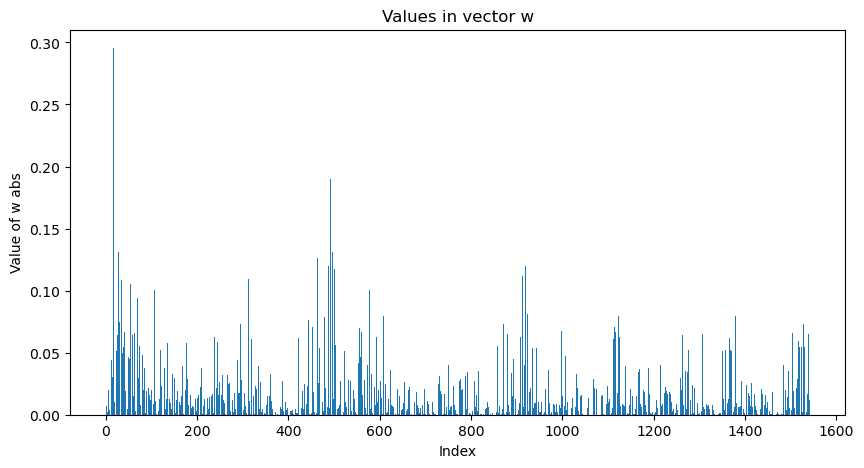

In [20]:
'''
Then we retrain our model with only the predictive features
'''

w_abs = np.abs(w)
plt.figure(figsize=(10, 5))
plt.bar(range(len(w_abs)), w_abs)
plt.xlabel("Index")
plt.ylabel("Value of w abs")
plt.title("Values in vector w")
plt.show()

In [24]:
def fit_with_t(w_abs, t, y_test, y_train, tx_test, tx, lambda_, initial_w, max_iter, gamma):
    w, train_loss = reg_logistic_regression(y_train, tx, lambda_, initial_w, max_iter, gamma)

    # Sigmoid gives a value between 0 and 1
    test_probs = sigmoid(tx_test @ w)
    # We round to the nearest to get our prediction in {0,1}
    # (which we will transform later into {-1,1} for submission
    test_preds = np.round(test_probs)
    test_error_rate = np.count_nonzero(y_test - test_preds) / len(y_test)
    test_accuracy = 1 - test_error_rate

    return compute_f1_score(y_test, test_preds), train_loss, test_accuracy

In [25]:
# We select the threshold methodically 
percentiles_to_test = np.arange(0.95, 0, -0.05) 
w_abs = np.abs(w)
threshold_w = [np.percentile(w_abs, p * 100) for p in percentiles_to_test]
tx_test = build_tx(X_test) 

f1_scores = []
train_losses = []
test_accuracies = []
for t in threshold_w: #todo add bias to tx_t and tx_test_t and w again 
    features_to_keep = w_abs > t
    tx_t = tx[:, features_to_keep] #we define a unique variable tx_t for each iteration not to mess with the original tx 
    initial_w = np.zeros((tx_t.shape[1]))
    tx_test_t = tx_test[:, features_to_keep] 

    f1, train_loss, test_accuracy = fit_with_t(w_abs, t, y_test, y_train, tx_test_t, tx_t, lambda_, initial_w, max_iter, gamma)

    train_losses.append(train_loss)
    f1_scores.append(f1)
    test_accuracies.append(test_accuracy)

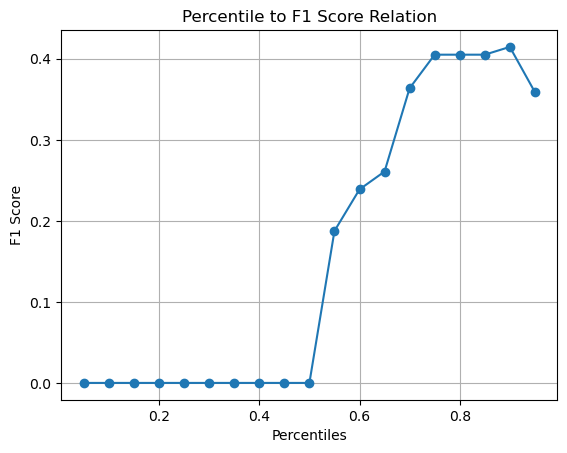

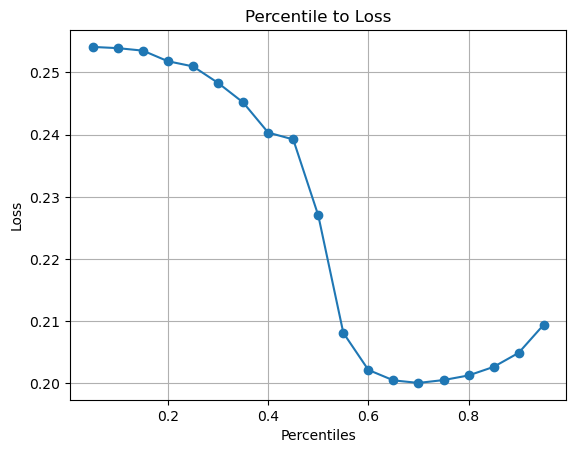

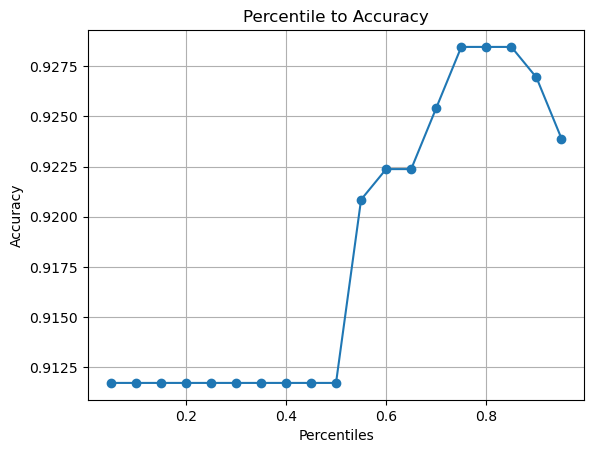

In [23]:
#plot threshold and score relation

# We only keep the features that have the biggest weight component in the weight vector
# learned with logistic regression. Rationale: low weight means the feature bears little
# importance in the predictions. So we can get rid on it to have a simpler model and avoid
# overfitting.

# Percentiles = Percentiles of most significant features kept
# Most significant = features with the biggest component the w of logistic regression

plt.plot(percentiles_to_test, f1_scores, marker='o')
plt.xlabel("Percentiles")
plt.ylabel("F1 Score")
plt.title("Percentile to F1 Score Relation")
plt.grid(True)
plt.show()

plt.plot(percentiles_to_test, losses, marker='o')
plt.xlabel("Percentiles")
plt.ylabel("Loss")
plt.title("Percentile to Loss")
plt.grid(True)
plt.show()

plt.plot(percentiles_to_test, accuracies, marker='o')
plt.xlabel("Percentiles")
plt.ylabel("Accuracy")
plt.title("Percentile to Accuracy")
plt.grid(True)
plt.show()